In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/dataset_kb/hm.zip"

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: hm/data/data/fluorite/image_0049765.jpeg  
  inflating: hm/data/data/fluorite/image_0049795.jpeg  
  inflating: hm/data/data/fluorite/image_0049798.jpeg  
  inflating: hm/data/data/fluorite/image_0049801.jpeg  
  inflating: hm/data/data/fluorite/image_0049802.jpeg  
  inflating: hm/data/data/fluorite/image_0049803.jpeg  
  inflating: hm/data/data/fluorite/image_0049807.jpeg  
  inflating: hm/data/data/fluorite/image_0049809.jpeg  
  inflating: hm/data/data/fluorite/image_0049810.jpeg  
  inflating: hm/data/data/fluorite/image_0049837.jpeg  
  inflating: hm/data/data/fluorite/image_0049838.jpeg  
  inflating: hm/data/data/fluorite/image_0049841.jpeg  
  inflating: hm/data/data/fluorite/image_0049842.jpeg  
  inflating: hm/data/data/fluorite/image_0049845.jpeg  
  inflating: hm/data/data/fluorite/image_0049849.jpeg  
  inflating: hm/data/data/fluorite/image_0049860.jpeg  
  inflating: hm/data/data/fluorite/image_0049

In [3]:
# ==============================================================================
# 0. IMPORT LIBRARY
# ==============================================================================
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import os

In [4]:
# ==============================================================================
# 1. ⚙️ SETUP & KONFIGURASI PROYEK
# ==============================================================================

# --- (INI PATH ANDA SESUAI SCREENSHOT) ---
# Path ini menunjuk ke folder yang berisi 5 folder kelas Anda
BASE_DIR = '/content/hm/data/data/'
# ---------------------------------

# Parameter untuk memproses gambar
IMG_SIZE = (150, 150)
BATCH_SIZE = 32 # Batch size 32 adalah standar yang baik
EPOCHS = 30     # 30 epoch adalah awalan yang baik untuk 5 kelas

In [5]:
# ==============================================================================
# 2. 🗂️ DATA COLLECTING & PREPROCESSING (MEMBUAT SPLIT DATA)
# ==============================================================================
print("--- 1. Memuat & Membagi Dataset ---")

# 'image_dataset_from_directory' akan memuat data dari BASE_DIR
# Ini akan berhasil karena file rusak diasumsikan sudah dihapus
full_dataset = tf.keras.utils.image_dataset_from_directory(
    BASE_DIR,
    shuffle=True,       # Acak data
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='int'    # Label sebagai angka (0, 1, 2, 3, 4)
)

# Kode ini akan otomatis mendeteksi 5 kelas Anda
class_names = full_dataset.class_names
num_classes = len(class_names)
print(f"Ditemukan {num_classes} kelas: {class_names}")

# Tentukan proporsi split data (70% train, 15% validasi, 15% test)
dataset_size = tf.data.experimental.cardinality(full_dataset).numpy()
train_size = int(dataset_size * 0.7)
val_size = int(dataset_size * 0.15)
test_size = dataset_size - train_size - val_size

# Pengecekan jika dataset terlalu kecil (jika salah satu split = 0 batch)
if train_size == 0 or val_size == 0 or test_size == 0:
    print("WARNING: Dataset terlalu kecil untuk dibagi 70/15/15.")
    # Bagi 80/20 dan gunakan data validasi untuk testing
    train_size = int(dataset_size * 0.8)
    val_size = dataset_size - train_size
    test_size = val_size # Set data test = data validasi

    train_dataset = full_dataset.take(train_size)
    validation_dataset = full_dataset.skip(train_size).take(val_size)
    test_dataset = validation_dataset # Gunakan data validasi sebagai data test
    print(f"Membagi ulang: {train_size} train, {val_size} validation, {test_size} test (menggunakan data validasi)")
else:
    # Bagi dataset secara normal
    train_dataset = full_dataset.take(train_size)
    validation_dataset = full_dataset.skip(train_size).take(val_size)
    test_dataset = full_dataset.skip(train_size + val_size).take(test_size)
    print(f"   -> {train_size} batches untuk Training")
    print(f"   -> {val_size} batches untuk Validation")
    print(f"   -> {test_size} batches untuk Test")

print("Dataset berhasil dibagi.")

--- 1. Memuat & Membagi Dataset ---
Found 11926 files belonging to 5 classes.
Ditemukan 5 kelas: ['azurite', 'baryte', 'cerussite', 'copper', 'fluorite']
   -> 261 batches untuk Training
   -> 55 batches untuk Validation
   -> 57 batches untuk Test
Dataset berhasil dibagi.



--- 2. Visualisasi Contoh Data ---


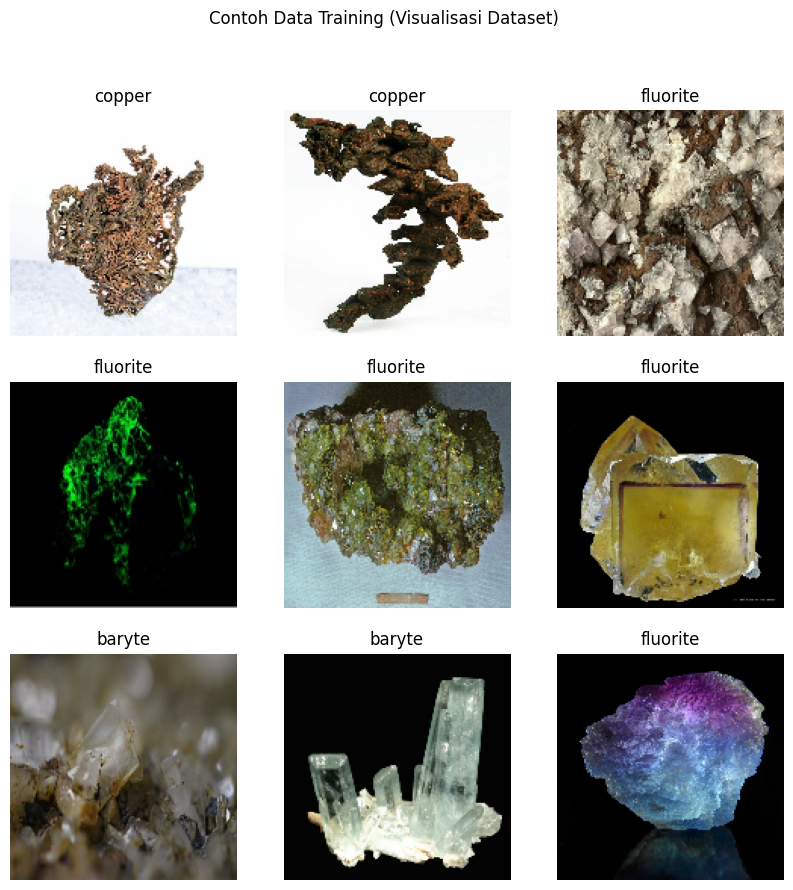

In [6]:
# ==============================================================================
# 3. 📊 DATA ANALISIS & VISUALISASI
# ==============================================================================
# Menampilkan 9 contoh gambar dari data training
print("\n--- 2. Visualisasi Contoh Data ---")
plt.figure(figsize=(10, 10))
plt.suptitle("Contoh Data Training (Visualisasi Dataset)")
for images, labels in train_dataset.take(1): # Ambil 1 batch
    # Pastikan tidak error jika batch pertama < 9 gambar
    for i in range(min(9, len(images))):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8")) # Tampilkan gambar
        plt.title(class_names[labels[i]]) # Tampilkan nama kelas
        plt.axis("off")
plt.show() # Tampilkan plot di Colab

In [7]:
# ==============================================================================
# 4. ⚡ OPTIMASI PIPELINE & NORMALISASI
# ==============================================================================
print("\n--- 3. Optimasi Pipeline Data ---")

# Buat layer Normalisasi (mengubah piksel [0, 255] menjadi [0, 1])
rescale_layer = layers.Rescaling(1./255)

# Terapkan Normalisasi ke semua dataset
AUTOTUNE = tf.data.AUTOTUNE # Untuk mempercepat proses
train_dataset = train_dataset.map(lambda x, y: (rescale_layer(x), y), num_parallel_calls=AUTOTUNE)
validation_dataset = validation_dataset.map(lambda x, y: (rescale_layer(x), y), num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.map(lambda x, y: (rescale_layer(x), y), num_parallel_calls=AUTOTUNE)
print("Normalisasi (Rescaling) diterapkan.")

# Terapkan .cache() dan .prefetch() untuk performa tinggi
# .cache() -> simpan data di RAM setelah epoch 1
# .prefetch() -> siapkan batch data berikutnya selagi GPU training
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)
print("Pipeline data dioptimasi dengan .cache() dan .prefetch().")


--- 3. Optimasi Pipeline Data ---
Normalisasi (Rescaling) diterapkan.
Pipeline data dioptimasi dengan .cache() dan .prefetch().


In [8]:
# ==============================================================================
# 5. 🧠 DATA MODELING (Arsitektur CNN dari Nol)
# ==============================================================================
print("\n--- 4. Membangun Arsitektur Model CNN ---")

# Definisikan layer Data Augmentation (untuk 'memperbanyak' data)
data_augmentation = models.Sequential(
    [
        layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ],
    name="data_augmentation"
)

# Membangun arsitektur model
model = models.Sequential([
    # Layer augmentasi (hanya aktif saat training)
    data_augmentation,

    # Blok Konvolusi 1
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(), # Menstabilkan training
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25), # Mencegah overfitting

    # Blok Konvolusi 2
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Blok Konvolusi 3
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # 'Kepala' Model (Classifier)
    layers.Flatten(), # Ubah gambar 2D jadi 1D
    layers.Dense(256, activation='relu'), # Layer tersembunyi (256 neuron)
    layers.BatchNormalization(),
    layers.Dropout(0.5), # Dropout lebih besar sebelum output

    # Output Layer
    # 'num_classes' akan bernilai 5, jadi ini akan punya 5 neuron
    layers.Dense(num_classes, activation='softmax', name="output_layer")
])


--- 4. Membangun Arsitektur Model CNN ---


In [9]:
# ==============================================================================
# 6. 🛠️ KOMPILASI MODEL (Konfigurasi Training)
# ==============================================================================
print("\n--- 5. Kompilasi Model ---")
# 'compile' mengkonfigurasi model untuk training
model.compile(
    optimizer='adam', # Optimizer paling umum
    loss='sparse_categorical_crossentropy', # Loss function untuk klasifikasi
    metrics=['accuracy'] # Metrik yang ingin dipantau
)

# Tampilkan rangkuman arsitektur
model.summary()


--- 5. Kompilasi Model ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    10,617,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,713,541 (40.87 MB)

 Trainable params: 10,712,581 (40.87 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# ==============================================================================
# 7. 🚀 TRAINING MODEL
# ==============================================================================
print("\n--- 6. Memulai Training Model ---")
# 'model.fit()' adalah proses melatih model
# PASTIKAN 'validation_data=validation_dataset' disertakan
history = model.fit(
    train_dataset,              # Data training
    epochs=EPOCHS,              # Jumlah epoch
    validation_data=validation_dataset # Data validasi
)
print("Training Selesai.")


--- 6. Memulai Training Model ---
Epoch 1/30
 22/261 ━━━━━━━━━━━━━━━━━━━━ 12:38 3s/step - accuracy: 0.4429 - loss: 1.4054